In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Flatten, CuDNNLSTM, Bidirectional, Input, GlobalAveragePooling1D
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D, concatenate
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

In [7]:
test_df = pd.read_csv('https://s3.amazonaws.com/ccwf-ml-data/jigsaw/processed_test.csv')
train_df = pd.read_csv('https://s3.amazonaws.com/ccwf-ml-data/jigsaw/processed_train.csv')

In [8]:
train_df['target'] = train_df['target'].apply(lambda x: 0 if x <= 0.5 else 1)

In [19]:
FAST_TEXT = 'crawl-300d-2M.vec'
GLOVE = 'glove.840B.300d.txt'

In [10]:
def get_embedding_matrix(mat_type):
    if mat_type == 'fasttext':
        embeddings_index = {}
        with codecs.open(FAST_TEXT, encoding='utf-8') as f:
            for line in tqdm(f):
                values = line.rstrip().rsplit(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        return embeddings_index
    elif mat_type == 'glove':
        tdf = pd.read_csv(GLOVE, sep=" ", index_col=0, 
                               header=None, quoting=csv.QUOTE_NONE)
        return dict(zip(tdf.index, tdf.values))

In [20]:
embeddings_index = get_embedding_matrix('glove')

In [21]:
y_train = train_df['target'].values

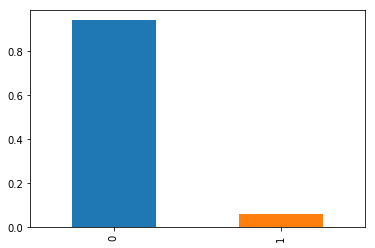

In [22]:
train_df['target'].value_counts(normalize=True).plot(kind='bar')

In [23]:
train_df.loc[(train_df['rating'] == 'rejected') & 
             (train_df['obscene'] > 0.1) & (train_df['severe_toxicity'] > 0), 'target'] = 1

In [24]:
processed_docs_train = train_df['processed_comment_text'].tolist()
processed_docs_test = test_df['processed_comment_text'].tolist()

In [25]:
print("tokenizing input data...")
tokenizer = Tokenizer(lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

tokenizing input data...
dictionary size:  315829


In [26]:
seq_lens = list(map(lambda x: len(x), word_seq_train))
empty_sequences = len(list(filter(lambda x: x == 0, seq_lens)))
print("Number of empty sequences in training:", empty_sequences)

Number of empty sequences in training: 220


In [27]:
MAX_SEQ_LEN = max(seq_lens)
VOCAB_SIZE = len(word_index)
EMBEDDED_DIMS = 300 

In [28]:
#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=MAX_SEQ_LEN)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=MAX_SEQ_LEN)

In [29]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDED_DIMS))
for word, i in word_index.items():
    if i >= VOCAB_SIZE:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 170436


In [32]:
LSTM_SEQ_LEN = 600

words = Input(shape=(None,), name='words')
emb = Embedding(VOCAB_SIZE, EMBEDDED_DIMS,
          weights=[embedding_matrix], input_length=MAX_SEQ_LEN, name='embedding')
X = emb(words)
X = SpatialDropout1D(0.2)(X)
X = CuDNNLSTM(LSTM_SEQ_LEN, return_sequences=True, name='RNN_Laye_1')(X)
X = CuDNNLSTM(LSTM_SEQ_LEN, return_sequences=True, name='RNN_Layer_2')(X)
hidden = concatenate([GlobalMaxPooling1D(name='max_pool')(X), GlobalAveragePooling1D(name='avg_pool')(X)])
hidden = Dense(LSTM_SEQ_LEN*2, activation='relu')(hidden)
result = Dense(1, activation='sigmoid')(hidden)
model = Model(inputs=words, outputs=result)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 540, 300)     94748700    words[0][0]                      
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 540, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
RNN_Laye_1 (CuDNNLSTM)          (None, 540, 600)     2164800     spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
RNN_Layer_

In [ ]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=256, epochs=16, 
                 validation_split=0.025, shuffle=True, verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1759752 samples, validate on 45122 samples
Epoch 1/16
  37120/1759752 [..............................] - ETA: 1:06:05 - loss: 0.1947 - acc: 0.9353

In [ ]:
y_test = model.predict(word_seq_test)

In [ ]:
#create a submission
submission_df = pd.DataFrame(columns=['id'])
submission_df['id'] = test_df['id'].values 
submission_df['prediction'] = y_test 
submission_df.to_csv("./rnn_fasttext_submission.csv", index=False)

In [ ]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()